# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

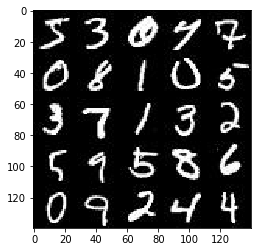

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

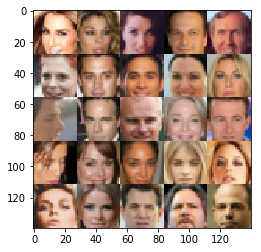

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')

    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\Rene\\Anaconda3\\envs\\dl_35\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\Rene\\Anaconda3\\envs\\dl_35\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\Rene\\Anaconda3\\envs\\dl_35\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\Rene\\Anaconda3\\envs\\dl_35\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\Rene\\Anaconda3\\envs\\dl_35\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "C:\\Users\\Re

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [52]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x1 or 28x28x3
        x1 = tf.layers.conv2d(images, 32, 5, strides=1, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 28x28x32
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x64
        
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14x128
        
        x4 = tf.layers.conv2d(relu3, 256, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu4, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [53]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 28x28x32 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # will be 28x28x1 or 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [54]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [55]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
     # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [56]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [57]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps=0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_images *= 2
                
               # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                # optimize generator again
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})

                
                #Print out every 100 steps
                if steps % 100 == 0:
                    show_generator_output(sess=sess, n_images = 10, input_z = input_z, out_channel_dim = data_shape[3], image_mode = data_image_mode)

                if steps % 10 == 0:

                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}... ".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
        
        print("Finished.")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2...  Discriminator Loss: 4.1895 Generator Loss: 0.0199
Epoch 1/2...  Discriminator Loss: 2.0615 Generator Loss: 2.1152
Epoch 1/2...  Discriminator Loss: 2.0000 Generator Loss: 0.5551
Epoch 1/2...  Discriminator Loss: 2.0752 Generator Loss: 0.8484
Epoch 1/2...  Discriminator Loss: 1.8738 Generator Loss: 0.6865
Epoch 1/2...  Discriminator Loss: 2.2947 Generator Loss: 1.1788
Epoch 1/2...  Discriminator Loss: 1.7040 Generator Loss: 0.4065
Epoch 1/2...  Discriminator Loss: 1.4173 Generator Loss: 0.7810
Epoch 1/2...  Discriminator Loss: 2.0462 Generator Loss: 0.4436


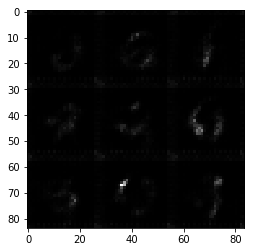

Epoch 1/2...  Discriminator Loss: 1.1831 Generator Loss: 0.5801
Epoch 1/2...  Discriminator Loss: 1.4104 Generator Loss: 1.1600
Epoch 1/2...  Discriminator Loss: 1.2752 Generator Loss: 1.1167
Epoch 1/2...  Discriminator Loss: 1.4509 Generator Loss: 0.4561
Epoch 1/2...  Discriminator Loss: 1.5304 Generator Loss: 1.1832
Epoch 1/2...  Discriminator Loss: 1.3994 Generator Loss: 0.6540
Epoch 1/2...  Discriminator Loss: 2.1711 Generator Loss: 1.8930
Epoch 1/2...  Discriminator Loss: 1.4880 Generator Loss: 1.5771
Epoch 1/2...  Discriminator Loss: 1.3821 Generator Loss: 1.1148
Epoch 1/2...  Discriminator Loss: 1.3559 Generator Loss: 1.4982


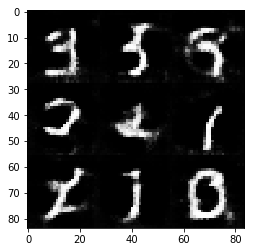

Epoch 1/2...  Discriminator Loss: 1.3674 Generator Loss: 1.0085
Epoch 1/2...  Discriminator Loss: 1.3925 Generator Loss: 1.2222
Epoch 1/2...  Discriminator Loss: 1.3596 Generator Loss: 0.7043
Epoch 1/2...  Discriminator Loss: 1.5703 Generator Loss: 0.3716
Epoch 1/2...  Discriminator Loss: 1.5615 Generator Loss: 0.4108
Epoch 1/2...  Discriminator Loss: 1.9181 Generator Loss: 0.2275
Epoch 1/2...  Discriminator Loss: 1.4791 Generator Loss: 1.4911
Epoch 1/2...  Discriminator Loss: 1.1355 Generator Loss: 1.0782
Epoch 1/2...  Discriminator Loss: 1.4509 Generator Loss: 0.6694
Epoch 1/2...  Discriminator Loss: 1.6774 Generator Loss: 0.3259


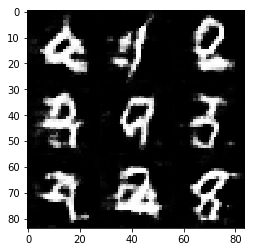

Epoch 1/2...  Discriminator Loss: 1.3824 Generator Loss: 0.4356
Epoch 1/2...  Discriminator Loss: 1.7168 Generator Loss: 1.8475
Epoch 1/2...  Discriminator Loss: 1.4770 Generator Loss: 1.0264
Epoch 1/2...  Discriminator Loss: 1.2807 Generator Loss: 1.0659
Epoch 1/2...  Discriminator Loss: 1.5204 Generator Loss: 1.5140
Epoch 1/2...  Discriminator Loss: 1.3577 Generator Loss: 0.9507
Epoch 1/2...  Discriminator Loss: 1.2272 Generator Loss: 0.7153
Epoch 1/2...  Discriminator Loss: 1.3690 Generator Loss: 0.4713
Epoch 1/2...  Discriminator Loss: 1.2306 Generator Loss: 0.9860
Epoch 1/2...  Discriminator Loss: 1.3037 Generator Loss: 0.7815


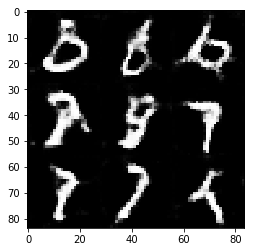

Epoch 1/2...  Discriminator Loss: 1.6665 Generator Loss: 0.2659
Epoch 1/2...  Discriminator Loss: 1.5217 Generator Loss: 1.5617
Epoch 1/2...  Discriminator Loss: 1.3096 Generator Loss: 0.7221
Epoch 1/2...  Discriminator Loss: 1.3448 Generator Loss: 0.8169
Epoch 1/2...  Discriminator Loss: 1.3306 Generator Loss: 1.0308
Epoch 1/2...  Discriminator Loss: 1.1193 Generator Loss: 0.9595
Epoch 1/2...  Discriminator Loss: 1.2815 Generator Loss: 0.8383
Epoch 1/2...  Discriminator Loss: 1.8807 Generator Loss: 0.2471
Epoch 1/2...  Discriminator Loss: 1.4012 Generator Loss: 0.7419
Epoch 1/2...  Discriminator Loss: 1.5517 Generator Loss: 1.4243


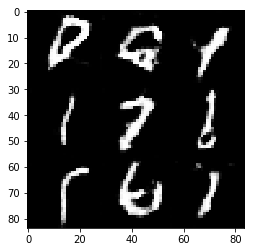

Epoch 1/2...  Discriminator Loss: 0.9961 Generator Loss: 1.0206
Epoch 1/2...  Discriminator Loss: 1.1764 Generator Loss: 0.8158
Epoch 1/2...  Discriminator Loss: 1.4636 Generator Loss: 0.3752
Epoch 1/2...  Discriminator Loss: 1.4343 Generator Loss: 0.9754
Epoch 1/2...  Discriminator Loss: 1.2634 Generator Loss: 0.7560
Epoch 1/2...  Discriminator Loss: 1.2272 Generator Loss: 0.6198
Epoch 1/2...  Discriminator Loss: 1.5386 Generator Loss: 1.2870
Epoch 1/2...  Discriminator Loss: 1.3813 Generator Loss: 0.6252
Epoch 1/2...  Discriminator Loss: 1.3965 Generator Loss: 1.7054
Epoch 1/2...  Discriminator Loss: 1.2032 Generator Loss: 0.5879


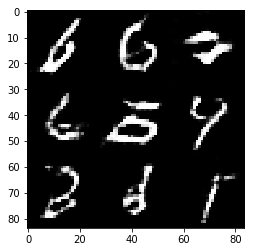

Epoch 1/2...  Discriminator Loss: 2.2782 Generator Loss: 0.1728
Epoch 1/2...  Discriminator Loss: 1.4632 Generator Loss: 0.7012
Epoch 1/2...  Discriminator Loss: 1.1732 Generator Loss: 0.6699
Epoch 1/2...  Discriminator Loss: 1.4445 Generator Loss: 0.4240
Epoch 1/2...  Discriminator Loss: 0.9340 Generator Loss: 0.8905
Epoch 1/2...  Discriminator Loss: 1.2587 Generator Loss: 1.1131
Epoch 1/2...  Discriminator Loss: 1.2311 Generator Loss: 0.8284
Epoch 1/2...  Discriminator Loss: 1.2606 Generator Loss: 0.8392
Epoch 1/2...  Discriminator Loss: 1.3687 Generator Loss: 0.6179
Epoch 1/2...  Discriminator Loss: 1.3827 Generator Loss: 0.5960


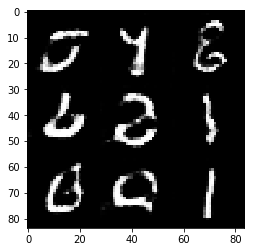

Epoch 1/2...  Discriminator Loss: 1.9757 Generator Loss: 1.7176
Epoch 1/2...  Discriminator Loss: 1.2366 Generator Loss: 0.6379
Epoch 1/2...  Discriminator Loss: 1.3662 Generator Loss: 0.5651
Epoch 1/2...  Discriminator Loss: 1.3114 Generator Loss: 1.0308
Epoch 1/2...  Discriminator Loss: 1.1448 Generator Loss: 1.3513
Epoch 1/2...  Discriminator Loss: 1.2670 Generator Loss: 0.4802
Epoch 1/2...  Discriminator Loss: 1.4460 Generator Loss: 2.0042
Epoch 1/2...  Discriminator Loss: 0.9847 Generator Loss: 0.8816
Epoch 1/2...  Discriminator Loss: 1.2880 Generator Loss: 1.4453
Epoch 1/2...  Discriminator Loss: 1.1545 Generator Loss: 0.7240


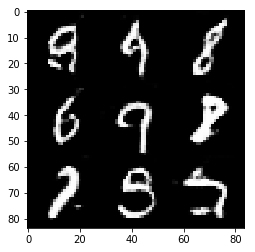

Epoch 1/2...  Discriminator Loss: 1.0772 Generator Loss: 0.8409
Epoch 1/2...  Discriminator Loss: 1.2303 Generator Loss: 1.0658
Epoch 1/2...  Discriminator Loss: 1.3290 Generator Loss: 0.4619
Epoch 1/2...  Discriminator Loss: 1.2691 Generator Loss: 1.2494
Epoch 1/2...  Discriminator Loss: 0.7542 Generator Loss: 1.2983
Epoch 1/2...  Discriminator Loss: 0.9901 Generator Loss: 1.0176
Epoch 1/2...  Discriminator Loss: 1.8532 Generator Loss: 0.3657
Epoch 1/2...  Discriminator Loss: 1.6764 Generator Loss: 1.1956
Epoch 1/2...  Discriminator Loss: 0.9752 Generator Loss: 1.1096
Epoch 1/2...  Discriminator Loss: 1.4956 Generator Loss: 0.3652


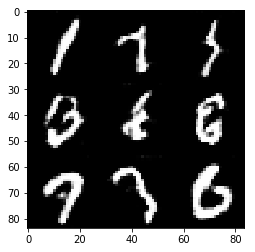

Epoch 1/2...  Discriminator Loss: 0.9457 Generator Loss: 0.8924
Epoch 1/2...  Discriminator Loss: 1.7812 Generator Loss: 1.9346
Epoch 1/2...  Discriminator Loss: 0.8787 Generator Loss: 1.2200
Epoch 1/2...  Discriminator Loss: 1.3834 Generator Loss: 1.4338
Epoch 2/2...  Discriminator Loss: 1.4722 Generator Loss: 0.4728
Epoch 2/2...  Discriminator Loss: 1.1508 Generator Loss: 0.9302
Epoch 2/2...  Discriminator Loss: 1.5680 Generator Loss: 0.3417
Epoch 2/2...  Discriminator Loss: 1.0144 Generator Loss: 0.9922
Epoch 2/2...  Discriminator Loss: 1.6914 Generator Loss: 0.3100
Epoch 2/2...  Discriminator Loss: 1.0493 Generator Loss: 1.2942


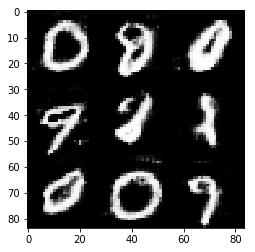

Epoch 2/2...  Discriminator Loss: 1.3102 Generator Loss: 0.7511
Epoch 2/2...  Discriminator Loss: 1.4361 Generator Loss: 0.4314
Epoch 2/2...  Discriminator Loss: 1.0338 Generator Loss: 1.1746
Epoch 2/2...  Discriminator Loss: 1.1658 Generator Loss: 0.6460
Epoch 2/2...  Discriminator Loss: 2.0501 Generator Loss: 1.6610
Epoch 2/2...  Discriminator Loss: 0.7785 Generator Loss: 1.2573
Epoch 2/2...  Discriminator Loss: 2.0684 Generator Loss: 0.2262
Epoch 2/2...  Discriminator Loss: 1.9177 Generator Loss: 0.2211
Epoch 2/2...  Discriminator Loss: 1.5729 Generator Loss: 0.4164
Epoch 2/2...  Discriminator Loss: 0.8428 Generator Loss: 1.0571


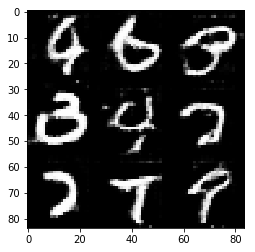

Epoch 2/2...  Discriminator Loss: 2.2086 Generator Loss: 2.3342
Epoch 2/2...  Discriminator Loss: 0.9756 Generator Loss: 1.0789
Epoch 2/2...  Discriminator Loss: 1.2644 Generator Loss: 0.5112
Epoch 2/2...  Discriminator Loss: 1.0236 Generator Loss: 1.0272
Epoch 2/2...  Discriminator Loss: 1.1484 Generator Loss: 0.6990
Epoch 2/2...  Discriminator Loss: 1.2489 Generator Loss: 0.5798
Epoch 2/2...  Discriminator Loss: 1.3749 Generator Loss: 0.5237
Epoch 2/2...  Discriminator Loss: 1.0285 Generator Loss: 1.4272
Epoch 2/2...  Discriminator Loss: 1.0542 Generator Loss: 0.6733
Epoch 2/2...  Discriminator Loss: 0.9575 Generator Loss: 0.8023


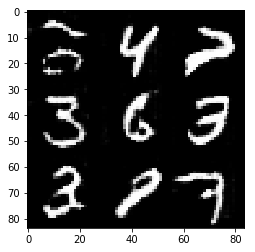

Epoch 2/2...  Discriminator Loss: 0.8827 Generator Loss: 0.9047
Epoch 2/2...  Discriminator Loss: 1.1246 Generator Loss: 1.2158
Epoch 2/2...  Discriminator Loss: 0.9159 Generator Loss: 1.1513
Epoch 2/2...  Discriminator Loss: 1.4832 Generator Loss: 0.3689
Epoch 2/2...  Discriminator Loss: 1.1414 Generator Loss: 0.6640
Epoch 2/2...  Discriminator Loss: 0.9443 Generator Loss: 2.5523
Epoch 2/2...  Discriminator Loss: 0.8510 Generator Loss: 0.8665
Epoch 2/2...  Discriminator Loss: 1.7271 Generator Loss: 0.2992
Epoch 2/2...  Discriminator Loss: 1.5446 Generator Loss: 0.4042
Epoch 2/2...  Discriminator Loss: 1.2127 Generator Loss: 0.6738


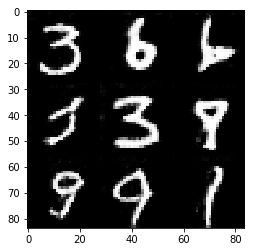

Epoch 2/2...  Discriminator Loss: 0.8979 Generator Loss: 1.3914
Epoch 2/2...  Discriminator Loss: 1.1554 Generator Loss: 0.6306
Epoch 2/2...  Discriminator Loss: 1.8389 Generator Loss: 1.1731
Epoch 2/2...  Discriminator Loss: 1.3851 Generator Loss: 0.5828
Epoch 2/2...  Discriminator Loss: 0.9479 Generator Loss: 1.2373
Epoch 2/2...  Discriminator Loss: 1.0559 Generator Loss: 0.7637
Epoch 2/2...  Discriminator Loss: 0.6085 Generator Loss: 2.1984
Epoch 2/2...  Discriminator Loss: 1.7222 Generator Loss: 2.3405
Epoch 2/2...  Discriminator Loss: 0.6720 Generator Loss: 1.5891
Epoch 2/2...  Discriminator Loss: 1.0377 Generator Loss: 0.7449


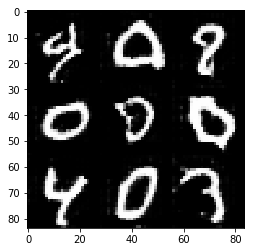

Epoch 2/2...  Discriminator Loss: 1.8708 Generator Loss: 2.3625
Epoch 2/2...  Discriminator Loss: 1.3211 Generator Loss: 0.5147
Epoch 2/2...  Discriminator Loss: 1.0894 Generator Loss: 1.7257
Epoch 2/2...  Discriminator Loss: 2.0526 Generator Loss: 0.2390
Epoch 2/2...  Discriminator Loss: 0.8487 Generator Loss: 1.3788
Epoch 2/2...  Discriminator Loss: 1.1290 Generator Loss: 0.6761
Epoch 2/2...  Discriminator Loss: 0.6113 Generator Loss: 1.3079
Epoch 2/2...  Discriminator Loss: 0.8872 Generator Loss: 1.7089
Epoch 2/2...  Discriminator Loss: 1.4431 Generator Loss: 0.5078
Epoch 2/2...  Discriminator Loss: 0.9958 Generator Loss: 0.6912


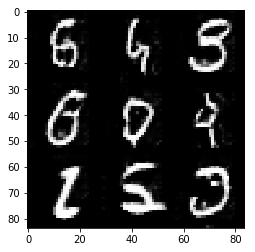

Epoch 2/2...  Discriminator Loss: 1.8287 Generator Loss: 0.3297
Epoch 2/2...  Discriminator Loss: 1.1239 Generator Loss: 0.7852
Epoch 2/2...  Discriminator Loss: 1.2925 Generator Loss: 0.4789
Epoch 2/2...  Discriminator Loss: 1.0434 Generator Loss: 1.5774
Epoch 2/2...  Discriminator Loss: 0.7697 Generator Loss: 1.1191
Epoch 2/2...  Discriminator Loss: 1.1544 Generator Loss: 0.8664
Epoch 2/2...  Discriminator Loss: 1.0553 Generator Loss: 1.0449
Epoch 2/2...  Discriminator Loss: 1.2977 Generator Loss: 0.6066
Epoch 2/2...  Discriminator Loss: 1.0671 Generator Loss: 0.7865
Epoch 2/2...  Discriminator Loss: 1.2334 Generator Loss: 0.8907


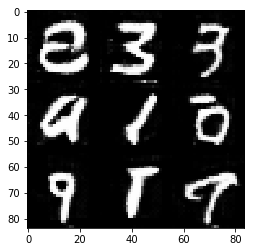

Epoch 2/2...  Discriminator Loss: 0.8860 Generator Loss: 1.0051
Epoch 2/2...  Discriminator Loss: 2.1858 Generator Loss: 0.2083
Epoch 2/2...  Discriminator Loss: 1.0122 Generator Loss: 1.4355
Epoch 2/2...  Discriminator Loss: 1.2522 Generator Loss: 0.7012
Epoch 2/2...  Discriminator Loss: 1.0713 Generator Loss: 1.7492
Epoch 2/2...  Discriminator Loss: 0.8560 Generator Loss: 1.5445
Epoch 2/2...  Discriminator Loss: 0.8589 Generator Loss: 0.9816
Epoch 2/2...  Discriminator Loss: 0.8918 Generator Loss: 1.2033
Epoch 2/2...  Discriminator Loss: 1.0263 Generator Loss: 1.5953
Epoch 2/2...  Discriminator Loss: 0.8845 Generator Loss: 0.8069


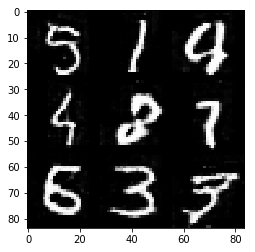

Epoch 2/2...  Discriminator Loss: 1.7281 Generator Loss: 0.3318
Epoch 2/2...  Discriminator Loss: 0.6786 Generator Loss: 1.3232
Epoch 2/2...  Discriminator Loss: 1.0312 Generator Loss: 0.8735
Epoch 2/2...  Discriminator Loss: 1.3634 Generator Loss: 0.5706
Epoch 2/2...  Discriminator Loss: 1.0491 Generator Loss: 0.8148
Epoch 2/2...  Discriminator Loss: 1.2375 Generator Loss: 2.3473
Epoch 2/2...  Discriminator Loss: 0.7218 Generator Loss: 1.2876
Epoch 2/2...  Discriminator Loss: 0.7372 Generator Loss: 1.2380
Epoch 2/2...  Discriminator Loss: 1.2126 Generator Loss: 0.7394
Epoch 2/2...  Discriminator Loss: 0.5920 Generator Loss: 1.1409


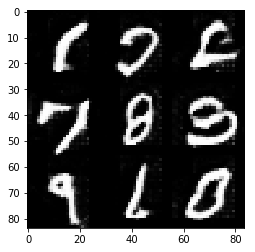

Epoch 2/2...  Discriminator Loss: 1.4015 Generator Loss: 0.5259
Epoch 2/2...  Discriminator Loss: 1.3065 Generator Loss: 1.4058
Epoch 2/2...  Discriminator Loss: 2.0764 Generator Loss: 0.2854
Epoch 2/2...  Discriminator Loss: 1.2317 Generator Loss: 0.6043
Epoch 2/2...  Discriminator Loss: 0.9567 Generator Loss: 0.7266
Epoch 2/2...  Discriminator Loss: 1.0212 Generator Loss: 1.0339
Epoch 2/2...  Discriminator Loss: 0.8197 Generator Loss: 1.1108
Epoch 2/2...  Discriminator Loss: 1.0228 Generator Loss: 0.7909
Finished.


In [58]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1...  Discriminator Loss: 6.4643 Generator Loss: 0.0049
Epoch 1/1...  Discriminator Loss: 3.1378 Generator Loss: 0.0888
Epoch 1/1...  Discriminator Loss: 1.8338 Generator Loss: 0.9198
Epoch 1/1...  Discriminator Loss: 1.7281 Generator Loss: 1.2449
Epoch 1/1...  Discriminator Loss: 1.8116 Generator Loss: 0.8460
Epoch 1/1...  Discriminator Loss: 1.4800 Generator Loss: 1.3715
Epoch 1/1...  Discriminator Loss: 1.1276 Generator Loss: 1.3181
Epoch 1/1...  Discriminator Loss: 1.8989 Generator Loss: 0.4945
Epoch 1/1...  Discriminator Loss: 1.6839 Generator Loss: 0.4364


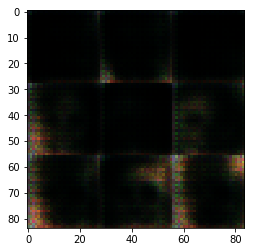

Epoch 1/1...  Discriminator Loss: 1.1188 Generator Loss: 2.6285
Epoch 1/1...  Discriminator Loss: 1.8649 Generator Loss: 0.2483
Epoch 1/1...  Discriminator Loss: 1.7593 Generator Loss: 0.2788
Epoch 1/1...  Discriminator Loss: 1.2845 Generator Loss: 1.6739
Epoch 1/1...  Discriminator Loss: 1.4589 Generator Loss: 0.6656
Epoch 1/1...  Discriminator Loss: 1.3798 Generator Loss: 0.8074
Epoch 1/1...  Discriminator Loss: 1.5468 Generator Loss: 0.4908
Epoch 1/1...  Discriminator Loss: 1.4492 Generator Loss: 0.5151
Epoch 1/1...  Discriminator Loss: 1.0105 Generator Loss: 1.7930
Epoch 1/1...  Discriminator Loss: 1.4355 Generator Loss: 1.4706


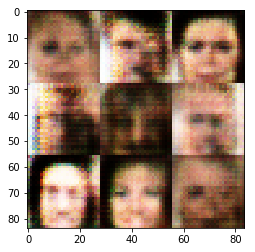

Epoch 1/1...  Discriminator Loss: 1.2251 Generator Loss: 0.6040
Epoch 1/1...  Discriminator Loss: 1.1854 Generator Loss: 0.5152
Epoch 1/1...  Discriminator Loss: 1.2483 Generator Loss: 0.7459
Epoch 1/1...  Discriminator Loss: 1.4954 Generator Loss: 0.6356
Epoch 1/1...  Discriminator Loss: 2.1778 Generator Loss: 2.6162
Epoch 1/1...  Discriminator Loss: 2.3660 Generator Loss: 0.2077
Epoch 1/1...  Discriminator Loss: 0.9956 Generator Loss: 1.8663
Epoch 1/1...  Discriminator Loss: 1.1831 Generator Loss: 0.9323
Epoch 1/1...  Discriminator Loss: 0.7013 Generator Loss: 1.2428
Epoch 1/1...  Discriminator Loss: 1.5869 Generator Loss: 0.3149


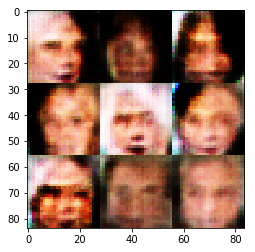

Epoch 1/1...  Discriminator Loss: 1.1849 Generator Loss: 0.6997
Epoch 1/1...  Discriminator Loss: 1.5040 Generator Loss: 0.4396
Epoch 1/1...  Discriminator Loss: 1.1995 Generator Loss: 0.5164
Epoch 1/1...  Discriminator Loss: 2.6837 Generator Loss: 2.5778
Epoch 1/1...  Discriminator Loss: 0.9066 Generator Loss: 0.9090
Epoch 1/1...  Discriminator Loss: 1.0260 Generator Loss: 0.6480
Epoch 1/1...  Discriminator Loss: 1.0772 Generator Loss: 1.4640
Epoch 1/1...  Discriminator Loss: 2.8722 Generator Loss: 4.5002
Epoch 1/1...  Discriminator Loss: 1.3628 Generator Loss: 0.5894
Epoch 1/1...  Discriminator Loss: 1.6372 Generator Loss: 0.6465


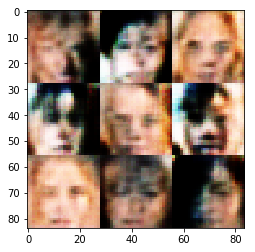

Epoch 1/1...  Discriminator Loss: 1.1878 Generator Loss: 0.7400
Epoch 1/1...  Discriminator Loss: 1.3657 Generator Loss: 0.6321
Epoch 1/1...  Discriminator Loss: 1.3476 Generator Loss: 0.6965
Epoch 1/1...  Discriminator Loss: 1.8974 Generator Loss: 0.2492
Epoch 1/1...  Discriminator Loss: 0.9154 Generator Loss: 0.8942
Epoch 1/1...  Discriminator Loss: 1.4500 Generator Loss: 0.3610
Epoch 1/1...  Discriminator Loss: 1.4708 Generator Loss: 0.4775
Epoch 1/1...  Discriminator Loss: 1.0379 Generator Loss: 0.7867
Epoch 1/1...  Discriminator Loss: 1.4536 Generator Loss: 0.4209
Epoch 1/1...  Discriminator Loss: 2.3506 Generator Loss: 0.1354


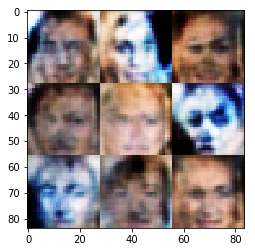

Epoch 1/1...  Discriminator Loss: 0.7805 Generator Loss: 1.0944
Epoch 1/1...  Discriminator Loss: 2.4591 Generator Loss: 0.1349
Epoch 1/1...  Discriminator Loss: 0.8979 Generator Loss: 1.6160
Epoch 1/1...  Discriminator Loss: 1.3277 Generator Loss: 1.4844
Epoch 1/1...  Discriminator Loss: 1.1803 Generator Loss: 0.5416
Epoch 1/1...  Discriminator Loss: 1.9010 Generator Loss: 1.8394
Epoch 1/1...  Discriminator Loss: 1.1938 Generator Loss: 0.6461
Epoch 1/1...  Discriminator Loss: 0.8972 Generator Loss: 3.2225
Epoch 1/1...  Discriminator Loss: 1.1868 Generator Loss: 0.9210
Epoch 1/1...  Discriminator Loss: 1.4066 Generator Loss: 0.7557


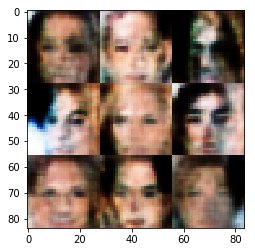

Epoch 1/1...  Discriminator Loss: 1.3873 Generator Loss: 0.7816
Epoch 1/1...  Discriminator Loss: 1.4470 Generator Loss: 0.5839
Epoch 1/1...  Discriminator Loss: 1.5136 Generator Loss: 0.5559
Epoch 1/1...  Discriminator Loss: 1.3887 Generator Loss: 0.6962
Epoch 1/1...  Discriminator Loss: 1.2441 Generator Loss: 0.7823
Epoch 1/1...  Discriminator Loss: 1.5110 Generator Loss: 0.8196
Epoch 1/1...  Discriminator Loss: 1.2333 Generator Loss: 0.8671
Epoch 1/1...  Discriminator Loss: 1.4587 Generator Loss: 0.5557
Epoch 1/1...  Discriminator Loss: 1.3280 Generator Loss: 0.6027
Epoch 1/1...  Discriminator Loss: 1.4088 Generator Loss: 0.6531


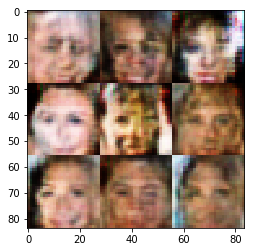

Epoch 1/1...  Discriminator Loss: 1.5779 Generator Loss: 0.5225
Epoch 1/1...  Discriminator Loss: 1.4401 Generator Loss: 0.8457
Epoch 1/1...  Discriminator Loss: 1.4247 Generator Loss: 0.6632
Epoch 1/1...  Discriminator Loss: 1.6112 Generator Loss: 0.4980
Epoch 1/1...  Discriminator Loss: 1.3764 Generator Loss: 0.6473
Epoch 1/1...  Discriminator Loss: 1.6815 Generator Loss: 0.6417
Epoch 1/1...  Discriminator Loss: 1.4398 Generator Loss: 0.6711
Epoch 1/1...  Discriminator Loss: 1.3951 Generator Loss: 0.7766
Epoch 1/1...  Discriminator Loss: 1.3815 Generator Loss: 0.6351
Epoch 1/1...  Discriminator Loss: 1.4944 Generator Loss: 0.7506


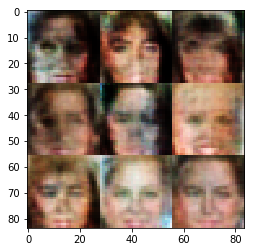

Epoch 1/1...  Discriminator Loss: 1.4170 Generator Loss: 0.6372
Epoch 1/1...  Discriminator Loss: 1.9526 Generator Loss: 0.3514
Epoch 1/1...  Discriminator Loss: 1.6562 Generator Loss: 0.5944
Epoch 1/1...  Discriminator Loss: 1.5514 Generator Loss: 0.6445
Epoch 1/1...  Discriminator Loss: 1.3817 Generator Loss: 0.8799
Epoch 1/1...  Discriminator Loss: 1.6314 Generator Loss: 0.4940
Epoch 1/1...  Discriminator Loss: 1.7187 Generator Loss: 0.9768
Epoch 1/1...  Discriminator Loss: 1.4096 Generator Loss: 0.6277
Epoch 1/1...  Discriminator Loss: 1.4644 Generator Loss: 0.5869
Epoch 1/1...  Discriminator Loss: 1.6088 Generator Loss: 0.9338


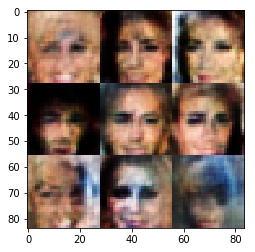

Epoch 1/1...  Discriminator Loss: 1.2935 Generator Loss: 0.9758
Epoch 1/1...  Discriminator Loss: 1.4158 Generator Loss: 0.7088
Epoch 1/1...  Discriminator Loss: 1.3667 Generator Loss: 0.6731
Epoch 1/1...  Discriminator Loss: 1.4647 Generator Loss: 0.5755
Epoch 1/1...  Discriminator Loss: 1.2154 Generator Loss: 0.8002
Epoch 1/1...  Discriminator Loss: 1.4912 Generator Loss: 0.7268
Epoch 1/1...  Discriminator Loss: 1.2202 Generator Loss: 0.7216
Epoch 1/1...  Discriminator Loss: 1.4629 Generator Loss: 0.7674
Epoch 1/1...  Discriminator Loss: 1.3575 Generator Loss: 0.7100
Epoch 1/1...  Discriminator Loss: 1.5357 Generator Loss: 0.7489


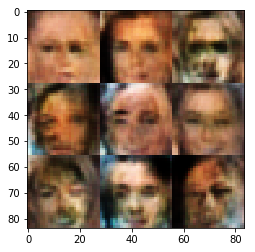

Epoch 1/1...  Discriminator Loss: 1.2584 Generator Loss: 0.7003
Epoch 1/1...  Discriminator Loss: 1.3016 Generator Loss: 1.1230
Epoch 1/1...  Discriminator Loss: 1.3413 Generator Loss: 0.9640
Epoch 1/1...  Discriminator Loss: 1.3499 Generator Loss: 0.5208
Epoch 1/1...  Discriminator Loss: 1.1859 Generator Loss: 1.3050
Epoch 1/1...  Discriminator Loss: 1.2846 Generator Loss: 0.8741
Epoch 1/1...  Discriminator Loss: 1.3849 Generator Loss: 0.9906
Epoch 1/1...  Discriminator Loss: 1.8094 Generator Loss: 0.2915
Epoch 1/1...  Discriminator Loss: 1.4217 Generator Loss: 0.4951
Epoch 1/1...  Discriminator Loss: 1.6085 Generator Loss: 0.5652


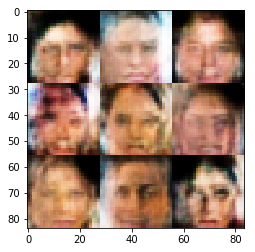

Epoch 1/1...  Discriminator Loss: 1.4503 Generator Loss: 0.6521
Epoch 1/1...  Discriminator Loss: 1.5807 Generator Loss: 1.1608
Epoch 1/1...  Discriminator Loss: 1.3530 Generator Loss: 0.6752
Epoch 1/1...  Discriminator Loss: 1.2235 Generator Loss: 0.7036
Epoch 1/1...  Discriminator Loss: 1.1754 Generator Loss: 0.7769
Epoch 1/1...  Discriminator Loss: 1.6346 Generator Loss: 1.4894
Epoch 1/1...  Discriminator Loss: 1.2286 Generator Loss: 2.1474
Epoch 1/1...  Discriminator Loss: 1.1756 Generator Loss: 0.7403
Epoch 1/1...  Discriminator Loss: 1.2981 Generator Loss: 0.5026
Epoch 1/1...  Discriminator Loss: 1.3624 Generator Loss: 0.9591


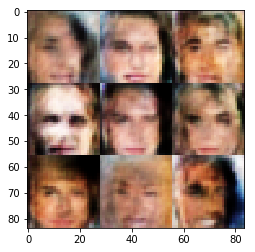

Epoch 1/1...  Discriminator Loss: 1.9048 Generator Loss: 0.2702
Epoch 1/1...  Discriminator Loss: 0.3343 Generator Loss: 1.4566
Epoch 1/1...  Discriminator Loss: 2.6872 Generator Loss: 0.1352
Epoch 1/1...  Discriminator Loss: 1.4394 Generator Loss: 0.6782
Epoch 1/1...  Discriminator Loss: 1.7820 Generator Loss: 0.3648
Epoch 1/1...  Discriminator Loss: 1.5854 Generator Loss: 0.5618
Epoch 1/1...  Discriminator Loss: 1.6912 Generator Loss: 0.4891
Epoch 1/1...  Discriminator Loss: 1.4071 Generator Loss: 0.9120
Epoch 1/1...  Discriminator Loss: 1.3364 Generator Loss: 0.9327
Epoch 1/1...  Discriminator Loss: 1.3442 Generator Loss: 0.9164


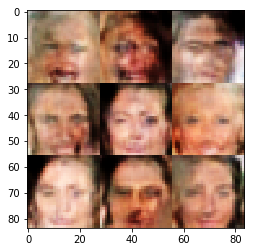

Epoch 1/1...  Discriminator Loss: 1.4546 Generator Loss: 0.4579
Epoch 1/1...  Discriminator Loss: 1.2671 Generator Loss: 0.8486
Epoch 1/1...  Discriminator Loss: 1.2505 Generator Loss: 0.5858
Epoch 1/1...  Discriminator Loss: 1.5589 Generator Loss: 0.4295
Epoch 1/1...  Discriminator Loss: 1.2524 Generator Loss: 1.1190
Epoch 1/1...  Discriminator Loss: 1.5237 Generator Loss: 0.4365
Epoch 1/1...  Discriminator Loss: 1.1518 Generator Loss: 1.0889
Epoch 1/1...  Discriminator Loss: 1.2529 Generator Loss: 0.7571
Epoch 1/1...  Discriminator Loss: 1.5466 Generator Loss: 0.4091
Epoch 1/1...  Discriminator Loss: 1.0051 Generator Loss: 1.3612


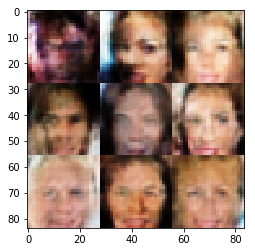

Epoch 1/1...  Discriminator Loss: 1.6207 Generator Loss: 0.5371
Epoch 1/1...  Discriminator Loss: 1.5109 Generator Loss: 0.6919
Epoch 1/1...  Discriminator Loss: 1.3131 Generator Loss: 0.7217
Epoch 1/1...  Discriminator Loss: 1.0396 Generator Loss: 1.3372
Epoch 1/1...  Discriminator Loss: 1.4041 Generator Loss: 0.8429
Epoch 1/1...  Discriminator Loss: 1.7256 Generator Loss: 0.3239
Epoch 1/1...  Discriminator Loss: 1.2536 Generator Loss: 0.9640
Epoch 1/1...  Discriminator Loss: 1.5590 Generator Loss: 0.8841
Epoch 1/1...  Discriminator Loss: 1.4647 Generator Loss: 0.5588
Epoch 1/1...  Discriminator Loss: 1.3766 Generator Loss: 1.1079


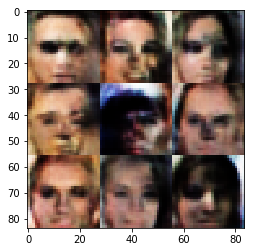

Epoch 1/1...  Discriminator Loss: 1.1031 Generator Loss: 1.5378
Epoch 1/1...  Discriminator Loss: 1.2903 Generator Loss: 1.2995
Epoch 1/1...  Discriminator Loss: 2.1324 Generator Loss: 2.0378
Epoch 1/1...  Discriminator Loss: 1.3240 Generator Loss: 0.7134
Epoch 1/1...  Discriminator Loss: 1.5012 Generator Loss: 0.6680
Epoch 1/1...  Discriminator Loss: 1.5455 Generator Loss: 0.5720
Epoch 1/1...  Discriminator Loss: 1.2924 Generator Loss: 0.7985
Epoch 1/1...  Discriminator Loss: 1.2260 Generator Loss: 0.9236
Epoch 1/1...  Discriminator Loss: 1.3664 Generator Loss: 0.7088
Epoch 1/1...  Discriminator Loss: 1.5009 Generator Loss: 0.5569


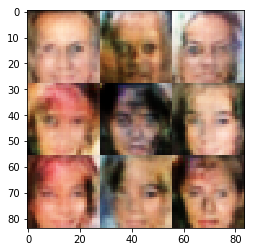

Epoch 1/1...  Discriminator Loss: 1.2689 Generator Loss: 0.6194
Epoch 1/1...  Discriminator Loss: 1.4890 Generator Loss: 0.7062
Epoch 1/1...  Discriminator Loss: 2.1834 Generator Loss: 0.2142
Epoch 1/1...  Discriminator Loss: 1.3013 Generator Loss: 0.9109
Epoch 1/1...  Discriminator Loss: 1.5031 Generator Loss: 0.5695
Epoch 1/1...  Discriminator Loss: 1.3353 Generator Loss: 0.9099
Epoch 1/1...  Discriminator Loss: 1.2545 Generator Loss: 0.7786
Epoch 1/1...  Discriminator Loss: 1.3583 Generator Loss: 0.5625
Epoch 1/1...  Discriminator Loss: 1.4206 Generator Loss: 0.9510
Epoch 1/1...  Discriminator Loss: 1.1775 Generator Loss: 0.9148


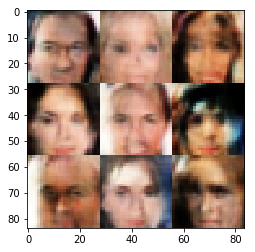

Epoch 1/1...  Discriminator Loss: 1.2934 Generator Loss: 1.1100
Epoch 1/1...  Discriminator Loss: 1.5832 Generator Loss: 0.4166
Epoch 1/1...  Discriminator Loss: 1.6072 Generator Loss: 0.4763
Epoch 1/1...  Discriminator Loss: 1.4332 Generator Loss: 0.5834
Epoch 1/1...  Discriminator Loss: 1.2470 Generator Loss: 0.7607
Epoch 1/1...  Discriminator Loss: 1.5289 Generator Loss: 0.4476
Epoch 1/1...  Discriminator Loss: 1.3815 Generator Loss: 0.6360
Epoch 1/1...  Discriminator Loss: 1.3776 Generator Loss: 0.6511
Epoch 1/1...  Discriminator Loss: 1.5706 Generator Loss: 0.3690
Epoch 1/1...  Discriminator Loss: 1.5094 Generator Loss: 0.5085


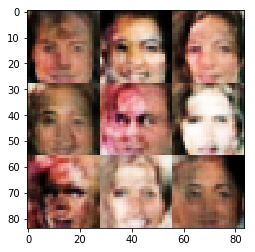

Epoch 1/1...  Discriminator Loss: 1.2435 Generator Loss: 0.6787
Epoch 1/1...  Discriminator Loss: 1.5513 Generator Loss: 0.5926
Epoch 1/1...  Discriminator Loss: 2.1530 Generator Loss: 0.1910
Epoch 1/1...  Discriminator Loss: 1.3699 Generator Loss: 1.1676
Epoch 1/1...  Discriminator Loss: 0.7710 Generator Loss: 0.7368
Epoch 1/1...  Discriminator Loss: 1.2139 Generator Loss: 0.8517
Epoch 1/1...  Discriminator Loss: 0.8451 Generator Loss: 1.9244
Epoch 1/1...  Discriminator Loss: 1.3967 Generator Loss: 0.6396
Epoch 1/1...  Discriminator Loss: 1.5469 Generator Loss: 0.4530
Epoch 1/1...  Discriminator Loss: 1.7688 Generator Loss: 0.3762


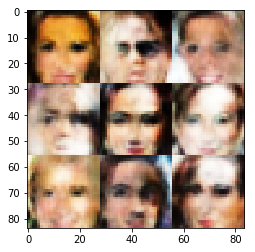

Epoch 1/1...  Discriminator Loss: 1.2858 Generator Loss: 0.9053
Epoch 1/1...  Discriminator Loss: 1.3738 Generator Loss: 0.6679
Epoch 1/1...  Discriminator Loss: 1.3727 Generator Loss: 0.7204
Epoch 1/1...  Discriminator Loss: 1.3946 Generator Loss: 1.1476
Epoch 1/1...  Discriminator Loss: 1.0731 Generator Loss: 0.9878
Epoch 1/1...  Discriminator Loss: 1.4951 Generator Loss: 0.3555
Epoch 1/1...  Discriminator Loss: 1.6881 Generator Loss: 0.3050
Epoch 1/1...  Discriminator Loss: 1.5052 Generator Loss: 0.3424
Epoch 1/1...  Discriminator Loss: 1.5604 Generator Loss: 0.6300
Epoch 1/1...  Discriminator Loss: 1.3401 Generator Loss: 0.9520


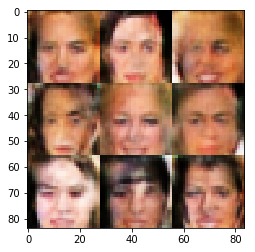

Epoch 1/1...  Discriminator Loss: 1.0963 Generator Loss: 0.8247
Epoch 1/1...  Discriminator Loss: 1.2089 Generator Loss: 0.8079
Epoch 1/1...  Discriminator Loss: 1.3752 Generator Loss: 0.6863
Epoch 1/1...  Discriminator Loss: 1.0278 Generator Loss: 1.0311
Epoch 1/1...  Discriminator Loss: 1.3693 Generator Loss: 0.6932
Epoch 1/1...  Discriminator Loss: 1.4259 Generator Loss: 0.8294
Epoch 1/1...  Discriminator Loss: 1.4677 Generator Loss: 0.5833
Epoch 1/1...  Discriminator Loss: 1.6777 Generator Loss: 0.3826
Epoch 1/1...  Discriminator Loss: 1.3620 Generator Loss: 0.5695
Epoch 1/1...  Discriminator Loss: 0.4875 Generator Loss: 2.7483


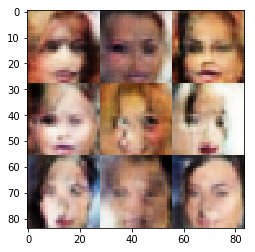

Epoch 1/1...  Discriminator Loss: 1.4748 Generator Loss: 0.5551
Epoch 1/1...  Discriminator Loss: 1.2397 Generator Loss: 0.5980
Epoch 1/1...  Discriminator Loss: 1.3820 Generator Loss: 0.5104
Epoch 1/1...  Discriminator Loss: 1.6037 Generator Loss: 0.3273
Epoch 1/1...  Discriminator Loss: 1.5166 Generator Loss: 1.1418
Epoch 1/1...  Discriminator Loss: 1.4270 Generator Loss: 2.0074
Epoch 1/1...  Discriminator Loss: 1.3260 Generator Loss: 0.4561
Epoch 1/1...  Discriminator Loss: 1.0657 Generator Loss: 0.6774
Epoch 1/1...  Discriminator Loss: 2.1740 Generator Loss: 0.1807
Epoch 1/1...  Discriminator Loss: 1.5442 Generator Loss: 0.3931


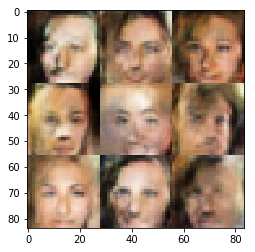

Epoch 1/1...  Discriminator Loss: 1.5692 Generator Loss: 0.5473
Epoch 1/1...  Discriminator Loss: 1.1492 Generator Loss: 0.7458
Epoch 1/1...  Discriminator Loss: 1.5133 Generator Loss: 0.4160
Epoch 1/1...  Discriminator Loss: 1.3063 Generator Loss: 1.5372
Epoch 1/1...  Discriminator Loss: 1.4767 Generator Loss: 0.6607
Epoch 1/1...  Discriminator Loss: 1.2229 Generator Loss: 0.9234
Epoch 1/1...  Discriminator Loss: 1.4234 Generator Loss: 1.5756
Epoch 1/1...  Discriminator Loss: 1.1380 Generator Loss: 0.8001
Epoch 1/1...  Discriminator Loss: 1.5981 Generator Loss: 0.3192
Epoch 1/1...  Discriminator Loss: 1.2994 Generator Loss: 1.3312


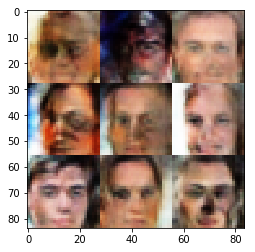

Epoch 1/1...  Discriminator Loss: 1.2303 Generator Loss: 1.3061
Epoch 1/1...  Discriminator Loss: 1.4288 Generator Loss: 0.7010
Epoch 1/1...  Discriminator Loss: 1.4489 Generator Loss: 0.4177
Epoch 1/1...  Discriminator Loss: 1.3644 Generator Loss: 1.3087
Epoch 1/1...  Discriminator Loss: 1.4604 Generator Loss: 0.5467
Epoch 1/1...  Discriminator Loss: 0.9176 Generator Loss: 1.0114
Epoch 1/1...  Discriminator Loss: 1.1673 Generator Loss: 1.0241
Epoch 1/1...  Discriminator Loss: 1.0420 Generator Loss: 0.8676
Epoch 1/1...  Discriminator Loss: 1.8958 Generator Loss: 2.3708
Epoch 1/1...  Discriminator Loss: 1.1538 Generator Loss: 0.7696


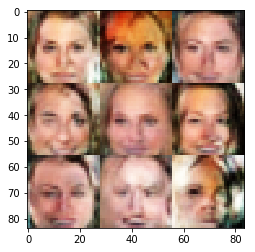

Epoch 1/1...  Discriminator Loss: 1.4524 Generator Loss: 0.4849
Epoch 1/1...  Discriminator Loss: 1.4163 Generator Loss: 0.5151
Epoch 1/1...  Discriminator Loss: 1.2788 Generator Loss: 0.6300
Epoch 1/1...  Discriminator Loss: 1.4026 Generator Loss: 0.6972
Epoch 1/1...  Discriminator Loss: 1.5104 Generator Loss: 0.5925
Epoch 1/1...  Discriminator Loss: 0.9341 Generator Loss: 1.4300
Epoch 1/1...  Discriminator Loss: 0.5350 Generator Loss: 1.3913
Epoch 1/1...  Discriminator Loss: 1.3338 Generator Loss: 0.9253
Epoch 1/1...  Discriminator Loss: 0.3554 Generator Loss: 3.4236
Epoch 1/1...  Discriminator Loss: 1.2006 Generator Loss: 1.4781


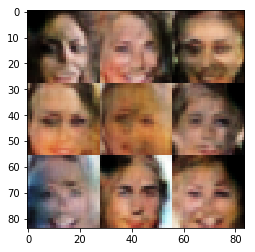

Epoch 1/1...  Discriminator Loss: 1.2181 Generator Loss: 0.8832
Epoch 1/1...  Discriminator Loss: 1.5362 Generator Loss: 0.5866
Epoch 1/1...  Discriminator Loss: 1.4375 Generator Loss: 0.5517
Epoch 1/1...  Discriminator Loss: 1.2112 Generator Loss: 0.9126
Epoch 1/1...  Discriminator Loss: 1.2691 Generator Loss: 0.7045
Epoch 1/1...  Discriminator Loss: 1.4054 Generator Loss: 0.7496
Epoch 1/1...  Discriminator Loss: 1.2315 Generator Loss: 0.6446
Epoch 1/1...  Discriminator Loss: 1.4659 Generator Loss: 0.6002
Epoch 1/1...  Discriminator Loss: 1.3307 Generator Loss: 0.5098
Epoch 1/1...  Discriminator Loss: 1.5894 Generator Loss: 0.4700


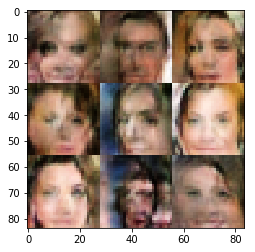

Epoch 1/1...  Discriminator Loss: 1.6762 Generator Loss: 0.3222
Epoch 1/1...  Discriminator Loss: 1.0249 Generator Loss: 1.1249
Epoch 1/1...  Discriminator Loss: 1.4005 Generator Loss: 0.7577
Epoch 1/1...  Discriminator Loss: 0.9075 Generator Loss: 1.0048
Epoch 1/1...  Discriminator Loss: 1.1896 Generator Loss: 2.3640
Epoch 1/1...  Discriminator Loss: 1.0285 Generator Loss: 1.6842
Epoch 1/1...  Discriminator Loss: 1.7896 Generator Loss: 0.4638
Epoch 1/1...  Discriminator Loss: 1.1074 Generator Loss: 1.7839
Epoch 1/1...  Discriminator Loss: 1.2284 Generator Loss: 0.5851
Epoch 1/1...  Discriminator Loss: 2.6853 Generator Loss: 0.1007


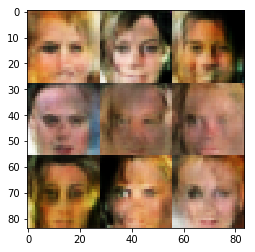

Epoch 1/1...  Discriminator Loss: 1.2525 Generator Loss: 0.5979
Epoch 1/1...  Discriminator Loss: 0.7508 Generator Loss: 1.5696
Epoch 1/1...  Discriminator Loss: 2.2774 Generator Loss: 0.1537
Epoch 1/1...  Discriminator Loss: 1.2506 Generator Loss: 1.4545
Epoch 1/1...  Discriminator Loss: 0.8053 Generator Loss: 1.5298
Epoch 1/1...  Discriminator Loss: 1.2191 Generator Loss: 0.5011
Epoch 1/1...  Discriminator Loss: 1.7076 Generator Loss: 0.2960
Epoch 1/1...  Discriminator Loss: 0.9782 Generator Loss: 1.1421
Epoch 1/1...  Discriminator Loss: 0.8978 Generator Loss: 2.5381
Epoch 1/1...  Discriminator Loss: 1.0341 Generator Loss: 0.6760


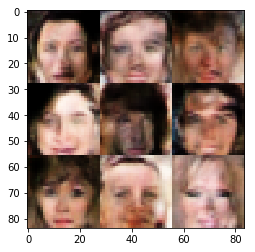

Epoch 1/1...  Discriminator Loss: 0.6716 Generator Loss: 1.6928
Epoch 1/1...  Discriminator Loss: 1.4255 Generator Loss: 0.5807
Epoch 1/1...  Discriminator Loss: 0.6489 Generator Loss: 1.0663
Epoch 1/1...  Discriminator Loss: 1.2667 Generator Loss: 1.0596
Epoch 1/1...  Discriminator Loss: 1.5120 Generator Loss: 0.5450
Epoch 1/1...  Discriminator Loss: 0.9746 Generator Loss: 2.7599
Epoch 1/1...  Discriminator Loss: 1.1267 Generator Loss: 0.6339
Epoch 1/1...  Discriminator Loss: 0.9543 Generator Loss: 1.3320
Epoch 1/1...  Discriminator Loss: 0.9311 Generator Loss: 3.9216
Epoch 1/1...  Discriminator Loss: 0.7911 Generator Loss: 1.8722


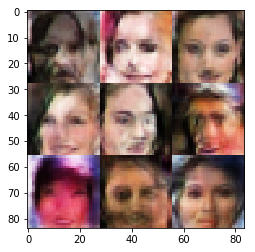

Epoch 1/1...  Discriminator Loss: 1.1916 Generator Loss: 0.5965
Epoch 1/1...  Discriminator Loss: 0.6735 Generator Loss: 1.4811
Epoch 1/1...  Discriminator Loss: 0.8049 Generator Loss: 2.9965
Epoch 1/1...  Discriminator Loss: 1.1720 Generator Loss: 0.9854
Epoch 1/1...  Discriminator Loss: 0.4347 Generator Loss: 1.5676
Epoch 1/1...  Discriminator Loss: 1.8122 Generator Loss: 0.2653
Epoch 1/1...  Discriminator Loss: 0.7900 Generator Loss: 1.0593
Epoch 1/1...  Discriminator Loss: 0.9079 Generator Loss: 1.2388
Epoch 1/1...  Discriminator Loss: 0.9415 Generator Loss: 4.1564
Epoch 1/1...  Discriminator Loss: 1.1668 Generator Loss: 1.4786


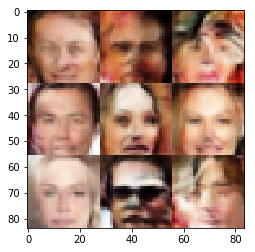

Epoch 1/1...  Discriminator Loss: 1.4066 Generator Loss: 0.4694
Epoch 1/1...  Discriminator Loss: 0.9754 Generator Loss: 1.8147
Epoch 1/1...  Discriminator Loss: 1.3974 Generator Loss: 2.1618
Epoch 1/1...  Discriminator Loss: 1.1497 Generator Loss: 2.5025
Epoch 1/1...  Discriminator Loss: 0.5495 Generator Loss: 2.0303
Epoch 1/1...  Discriminator Loss: 0.6915 Generator Loss: 1.1376
Epoch 1/1...  Discriminator Loss: 0.6415 Generator Loss: 1.7437
Epoch 1/1...  Discriminator Loss: 1.3657 Generator Loss: 0.6225
Epoch 1/1...  Discriminator Loss: 1.4764 Generator Loss: 0.4890
Epoch 1/1...  Discriminator Loss: 1.3926 Generator Loss: 1.0613


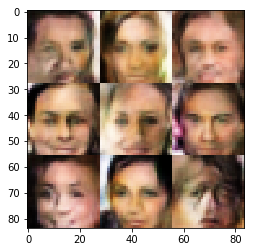

Epoch 1/1...  Discriminator Loss: 1.1426 Generator Loss: 0.9591
Epoch 1/1...  Discriminator Loss: 1.3059 Generator Loss: 0.6952
Epoch 1/1...  Discriminator Loss: 1.1077 Generator Loss: 0.8200
Epoch 1/1...  Discriminator Loss: 1.5519 Generator Loss: 0.5227
Epoch 1/1...  Discriminator Loss: 0.9934 Generator Loss: 1.4315
Epoch 1/1...  Discriminator Loss: 1.2326 Generator Loss: 1.1150
Epoch 1/1...  Discriminator Loss: 0.6607 Generator Loss: 1.5419
Finished.


In [59]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.